In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import sentencepiece as spm

import math
import os
import re
import urllib.request
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import csv

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# 데이터 전처리
- 공백, 특수문자 처리
- tokenization
- pair

In [3]:
# 간단한 전처리 함수
def preprocess_sentence(sentence):
  # 입력받은 sentence의 양쪽 공백을 제거
  sentence = sentence.strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,~])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (가-힣, a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r"[^가-힣a-zA-Z0-9?.!~,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence

# 테스트
sample_sentence = "안녕하세요? 우리 집 강아지 이름은 뽀삐랍니당~"

preprocessed_sentence = preprocess_sentence(sample_sentence)
print(preprocessed_sentence)

안녕하세요 ? 우리 집 강아지 이름은 뽀삐랍니당 ~


In [4]:
data_path = os.getcwd().replace("\\", "/") + "/ChatbotData.csv"
print(data_path)

def read_chatbot_data(data_path, max_samples=11824):
    pairs = []
    max = 0
    with open(data_path, 'r') as f:
        reader = csv.reader(f, delimiter=',', quotechar='"')
        
        for i, row in enumerate(reader):
            if len(row) >= 2:
                q, a = row[0], row[1]

                # 간단한 전처리
                q = preprocess_sentence(q)
                a = preprocess_sentence(a)
                
                pairs.append((q, a))

            if i == max_samples:
                return pairs

    return pairs


pairs = read_chatbot_data(data_path, max_samples=120000)
pairs = pairs[1:]

# 잘 되었나 확인해보기... 따옴표(" ") 안에 있는 ","는 구분자가 아님에 주의
print(len(pairs))
print(pairs[27])
print(pairs[:3])

c:/Users/suhol/workspace/aiffel_prac/nlp_1103/ChatbotData.csv
11823
('가족관계 알려 줘', '저를 만들어 준 사람을 부모님 , 저랑 이야기해 주는 사람을 친구로 생각하고 있어요')
[('12시 땡 !', '하루가 또 가네요 .'), ('1지망 학교 떨어졌어', '위로해 드립니다 .'), ('3박4일 놀러가고 싶다', '여행은 언제나 좋죠 .')]


# SentencePiece 사용하기

In [5]:
corpus_file = "proj_clean_corpus.txt"

with open(corpus_file, 'w') as f:
    for q, a in pairs:
        f.write(q + "\n")
        f.write(a + "\n")

In [6]:
# 해당 파일을 이용해 SentencePiece 모델을 훈련하고 tokenizer가 담길 model/vocab 파일 생성
spm.SentencePieceTrainer.Train(
    input=corpus_file,
    model_prefix="spm_chatbot",
    vocab_size=10000,
    character_coverage=0.9995,
    model_type="bpe",
    max_sentence_length=999999,
    bos_id=1,  # <s> (Beginning of Sentence) 설정
    eos_id=2,  # </s> (End of Sentence) 설정
    pad_id=0,  # Padding ID 설정
    unk_id=3   # Unknown Token ID 설정
)

In [7]:
# 학습시킨 tokenizer를 불러와 테스트
sp = spm.SentencePieceProcessor()
sp.Load("spm_chatbot.model")

# 예제 문장
sentence = "우리 집 강아지는 귀엽다!.."

sentence = preprocess_sentence(sentence)
print("전처리 후의 문장:", sentence)

# 1. 토크나이징 (subword 단위로 분할)
tokens = sp.encode(sentence, out_type=str)
print("Tokenized:", tokens)

# 2. 인코딩 (서브워드를 정수 ID로 변환)
encoded = sp.encode(sentence, out_type=int)
print("Encoded:", encoded)

# 3. 디코딩 (정수 ID → 원본 문장 복원)
decoded = sp.decode(encoded)
print("Decoded:", decoded)

전처리 후의 문장: 우리 집 강아지는 귀엽다 ! . .
Tokenized: ['▁우리', '▁집', '▁강', '아', '지는', '▁귀엽', '다', '▁!', '▁.', '▁.']
Encoded: [650, 179, 890, 8935, 388, 1800, 8938, 108, 4, 4]
Decoded: 우리 집 강아지는 귀엽다 ! . .


In [8]:
class ChatbotDataset(Dataset):
    """
    Dataset 준비를 위한 클래스
    """
    def __init__(self, pairs, sp, max_length):
        super().__init__()
        self.sp = sp
        self.max_length = max_length
        self.data = []
        
        for q_text, a_text in pairs:
            # 1) 토크나이즈
            q_ids = sp.EncodeAsIds(q_text)
            a_ids = sp.EncodeAsIds(a_text)

            # 2) [CLS]/[SEP] 같은 별도 스페셜 토큰을 쓸 수도 있으나,
            #    여기서는 SentencePiece 기본 <s>, </s> 등 혹은 사용자 정의 토큰 활용 가능
            #    간단히 <s>=sp.bos_id(), </s>=sp.eos_id()로 가정해본다면:
            #    sp.SetEncodeExtraOptions("bos:eos") 등으로 설정하는 방법도 있음.
            # 여기서는 수동으로 bos/eos id를 붙인다고 가정
            bos_id = sp.bos_id() if sp.bos_id() >= 0 else 1  # 혹은 임의값
            eos_id = sp.eos_id() if sp.eos_id() >= 0 else 2

            q_tokens = [bos_id] + q_ids + [eos_id]
            a_tokens = [bos_id] + a_ids + [eos_id]

            # 3) 길이 제한
            if len(q_tokens) > max_length or len(a_tokens) > max_length:
                continue

            # 4) 고정 길이 패딩
            q_tokens += [0]*(max_length - len(q_tokens))  # 0 -> <pad> 가정
            a_tokens += [0]*(max_length - len(a_tokens))

            # 5) 디코더 입력(dec_input): a_tokens[:-1], 타겟(outputs): a_tokens[1:]
            #    (teacher forcing용)
            dec_input = a_tokens[:-1]
            target = a_tokens[1:]

            self.data.append({
                "enc_input": q_tokens,
                "dec_input": dec_input,
                "target": target
            })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        enc_input = torch.tensor(sample["enc_input"], dtype=torch.long)
        dec_input = torch.tensor(sample["dec_input"], dtype=torch.long)
        target = torch.tensor(sample["target"], dtype=torch.long)
        return enc_input, dec_input, target
        

max length 지정을 위해 히스토그램으로 시각화

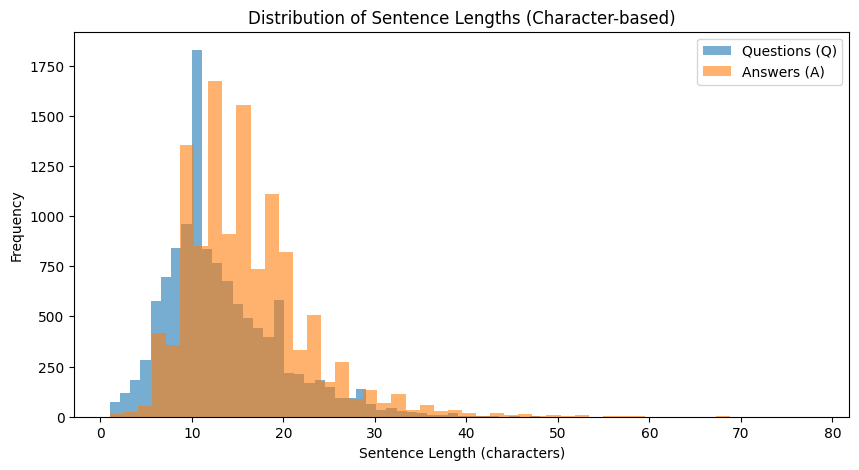

In [9]:
q_lens = [len(q) for q, _ in pairs]
a_lens = [len(a) for _, a in pairs]

plt.figure(figsize=(10, 5))
plt.hist(q_lens, bins=50, alpha=0.6, label='Questions (Q)')
plt.hist(a_lens, bins=50, alpha=0.6, label='Answers (A)')
plt.xlabel('Sentence Length (characters)')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Lengths (Character-based)')
plt.legend()
plt.show()


max_length 값을 변경해가며 전체 문장 중 몇 %가 max_length 이하에 속하는지 확인하기

In [10]:
max_length = 30
num_texts = len(pairs) * 2
temp = 0

for q, a in pairs:
    if len(q) <= max_length:
        temp += 1
    if len(a) <= max_length:
        temp += 1

print(f"전체 문장 중 길이가 {max_length} 이하인 문장의 비율 : {round(temp/num_texts, 3)}")

전체 문장 중 길이가 30 이하인 문장의 비율 : 0.972


In [11]:
dataset = ChatbotDataset(pairs, sp, max_length)

for encoder_input, decoder_input, decoder_label in dataset:
    print("텐서 크기 :",encoder_input.size())
    print(encoder_input)
    print(sp.decode(encoder_input.tolist()))
    print(decoder_input)
    print(sp.decode(decoder_input.tolist()))
    print(decoder_label)
    print(sp.decode(decoder_label.tolist()))
    break

텐서 크기 : torch.Size([30])
tensor([   1, 5554, 8970, 3203,  108,    2,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0])
12시 땡 !
tensor([   1, 4487,  214, 5924,    4,    2,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0])
하루가 또 가네요 .
tensor([4487,  214, 5924,    4,    2,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0])
하루가 또 가네요 .


dataloader는 train할 때 생성

In [12]:
dataloader = DataLoader(
        dataset,
        batch_size=32,
        shuffle=True,
    )

# 모델 구성하기

In [13]:
class PositionalEncoding(nn.Module):
    """
    Positional Encoding 구현 class
    토큰의 순서 정보를 모델에 제공하기 위함

    Args:
        position(int) : 문장에서 고려할 최대 sequence의 길이
        d_model(int) : 임베딩 벡터의 차원 수

    Methods:
        _get_angles(position, i, d_model):
            각 위치(position)와 임베딩 차원(i)에 대한 angle 값을 계산
            Returns:
                torch.Tensor: (position, d_model) 형태의 각도 행렬

        _build_pos_encoding(position, d_model):
            사인(sin)과 코사인(cos) 함수를 이용해 위치 인코딩 행렬을 생성
            Returns:
                torch.Tensor: [1, position, d_model] 형태의 위치 인코딩 텐서

        forward(x):
            입력 임베딩 텐서에 위치 인코딩을 더함
            Args:
                x (torch.Tensor): (batch_size, seq_len, d_model)
            Returns:
                torch.Tensor: (batch_size, seq_len, d_model)
    """
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.position = position

        self.pos_encoding = self._build_pos_encoding(position, d_model)

    def _get_angles(self, position, i, d_model):
        return 1.0 / (10000.0 ** ((2.0 * (i // 2)) / d_model)) * position

    def _build_pos_encoding(self, position, d_model):
        # 0~position까지 연속된 tensor를 생성한 후, 차원 추가(차원 위치(1)에 새로운 차원 추가)
        # shape : (position, 1)
        pos = torch.arange(position, dtype=torch.float32).unsqueeze(1)

        # 0~d_model까지 연속된 tensor를 생성한 후, 차원 추가(차원 위치(0)에 새로운 차원 추가)
        # shape : (1, d_model)
        i = torch.arange(d_model, dtype=torch.float32).unsqueeze(0)

        # angle_rads의 shape : (position, d_model)
        angle_rads = self._get_angles(pos, i, d_model)

        # 임베딩 벡터에 대하여 i가 짝수인 경우 다음 적용
        sines = torch.sin(angle_rads[:, 0::2])

        # 임베딩 벡터에 대하여 i가 홀수인 경우 다음 적용
        cosines = torch.cos(angle_rads[:, 1::2])

        pos_encoding = torch.zeros(position, d_model)
        pos_encoding[:, 0::2] = sines
        pos_encoding[:, 1::2] = cosines
        
        # shape: [1, position, d_model]
        pos_encoding = pos_encoding.unsqueeze(0)  
        return pos_encoding

    def forward(self, x):
        return x + self.pos_encoding[:, :x.size(1), :].to(x.device)

In [14]:
def scaled_dot_product_attention(query, key, value, mask=None):
    """
    Query, Key, Value에 대해 Scaled dot product 수행

    Args:
        query: (batch_size, heads, seq_len, depth)
        key: (batch_size, heads, seq_len, depth)
        value: (batch_size, heads, seq_len, depth_v)
        mask: (batch_size, 1, 1, seq_len) 또는 (batch_size, 1, seq_len, seq_len)
               마스킹할 위치에 1을, 유지할 위치에 0을 가진 텐서
    
    Returns:
        weighted_sum: (batch_size, heads, seq_len, depth_v)
        attention_weights: (batch_size, heads, seq_len, seq_len)
    """

    # 1) Q와 K의 내적을 통해 score(유사도) 계산
    # key.transpose(-1, -2): 마지막 두 차원만 transpose
    # (batch_size, heads, seq_len, depth) -> (batch_size, heads, depth, seq_len)
    key_t = key.transpose(-1, -2)
    # matmul: 주어진 tensor에 대해 행렬곱 진행(3d 이상인 경우, 행렬곱은 batch_size만큼 진행)
    # matmul 이후의 shape: (batch_size, heads, seq_len, seq_len)
    matmul_qk = torch.matmul(query, key_t)

    # 2) scaling 진행
    depth = key.size(-1)  # depth = d_model / heads
    logits = matmul_qk / math.sqrt(depth)

    # 3) 마스크가 주어졌다면 -1e9(아주 작은 값)를 더해 소프트맥스에서 제외시키도록 함
    if mask is not None:
        # 텐서플로우: logits += (mask * -1e9)
        # 파이토치 동일 적용
        logits = logits + (mask * -1e9)

    # 4) 소프트맥스 계산해 attention weights 생성
    attention_weights = F.softmax(logits, dim=-1)

    # 5) Weighted sum: attention weights와 value의 내적
    weighted_sum = torch.matmul(attention_weights, value)

    return weighted_sum, attention_weights

In [15]:
class MultiHeadAttention(nn.Module):
    """
    Multi-Head Attention을 구현한 클래스

    Args:
        d_model(int): Embedding matrix의 차원
        num_heads(int): head의 개수
        name(str): 모듈 이름
    
    Attributes:
        query_dense (nn.Linear): Query를 d_model 차원으로 변환하는 linear layer
        key_dense (nn.Linear): Key를 d_model 차원으로 변환하는 linear layer
        value_dense (nn.Linear): Value를 d_model 차원으로 변환하는 linear layer
        out_dense (nn.Linear): Attention 결과를 다시 d_model 차원으로 변환하는 linear layer
        depth (int): 각 head가 담당하는 차원 수 (d_model / num_heads)
    
    """
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        # d_model은 num_heads로 나누어떨어져야 함
        assert d_model % num_heads == 0

        # 각 head의 담당 차원 수
        self.depth = d_model // num_heads

        # 파이토치에서 Dense는 nn.Linear로 대응
        # 각각의 query, key, value는 저마다의 학습 가능한 파라미터와 입력 임베딩 벡터의 연산으로 결정됨
        # Q = X*W_q, K = X*W_k, V = X*W_v
        self.query_dense = nn.Linear(d_model, d_model)
        self.key_dense = nn.Linear(d_model, d_model)
        self.value_dense = nn.Linear(d_model, d_model)

        # 각 head의 attention 결과를 concat하고 그 결과는 linear layer를 통과한 후 반환됨
        self.out_dense = nn.Linear(d_model, d_model)

    def split_heads(self, x, batch_size):
        """
        d_model을 head의 개수에 따른 차원 수로 표현할 수 있도록 tensor의 shape 변환

        Args:
            x: (batch_size, seq_len, d_model) 형태

        Returns:
            x: (batch_size, num_heads, seq_len, depth) 형태
        """
        x = x.view(batch_size, -1, self.num_heads, self.depth) # (batch_size, seq_len, num_heads, depth)
        x = x.permute(0, 2, 1, 3)  # (batch_size, num_heads, seq_len, depth)로 순서 변경
        return x

    def forward(self, query, key, value, mask=None):
        """
        query, key, value: (batch_size, seq_len, d_model)
        mask: (batch_size, 1, seq_len, seq_len) 등으로 broadcast 가능하도록 구성
        """
        batch_size = query.size(0)

        # Q, K, V에 각각 Linear 적용
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # Head 분할
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 각 head에 대해 scaled_attention 진행 후 weighted_sum 저장
        scaled_attention_weighted_sum, _ = \
            scaled_dot_product_attention(query, key, value, mask)

        # (batch_size, num_heads, seq_len, depth) -> (batch_size, seq_len, num_heads, depth)
        scaled_attention_weighted_sum = \
            scaled_attention_weighted_sum.permute(0, 2, 1, 3).contiguous()

        # 각각의 head를 다시 (batch_size, seq_len, d_model)로 concat
        concat_scaled_attention_weighted_sum = \
            scaled_attention_weighted_sum.view(batch_size, -1, self.d_model)

        # 그 결과를 linear layer에 통과 시켜 선형 변환 후 반환
        output = self.out_dense(concat_scaled_attention_weighted_sum)
        return output

In [16]:
def create_padding_mask(x):
    """
    Embedding matrix에 대하여 padding(0)을 1로 변환하고 
    나중에 (batch_size, heads, seq_len, d)로 shape을 변환해야 하기 때문에 미리 matrix의 차원 수 늘려주기
    """
    # x == 0 위치를 찾아 float형 1로 변환
    mask = (x == 0).float()
    # (batch_size, seq_len) -> (batch_size, 1, 1, seq_len)
    mask = mask.unsqueeze(1).unsqueeze(2)
    return mask

def create_look_ahead_mask(x):
    """
    Embedding matrix에 대하여 query 이후의 단어들은 모두 1로 변환하고,
    query 이전의 단어들에 대하여 padding(0)이 있을 경우, 이들도 모두 1로 변환
    그리고 차원 수를 늘려서 반환해줌
    """
    seq_len = x.size(1)

    # (seq_len, seq_len) 크기의 lower triangular matrix(대각선 기준 위쪽이 모두 0) 생성 후 1에서 빼서
    # Upper triangular matrix 1, Lower triangular matrix(자기 자신 포함)이 0이 되도록 설정
    # => 미래 토큰(자신 인덱스보다 큰 위치) 마스킹
    look_ahead_mask = 1 - torch.tril(torch.ones((seq_len, seq_len)))

    # 패딩 마스크 생성 (shape: (batch_size, 1, 1, seq_len))
    padding_mask = create_padding_mask(x)

    # look_ahead_mask: (seq_len, seq_len) -> (1, seq_len, seq_len)
    look_ahead_mask = look_ahead_mask.unsqueeze(0)
    # -> (1, seq_len, seq_len) -> (1, 1, seq_len, seq_len)
    look_ahead_mask = look_ahead_mask.unsqueeze(1)
    look_ahead_mask = look_ahead_mask.to(x.device)

    # look-ahead 마스크와 패딩 마스크를 합성 (둘 중 하나라도 1이면 마스킹)
    # 최종 shape은 브로드캐스팅으로 (batch_size, 1, seq_len, seq_len)
    combined_mask = torch.max(look_ahead_mask, padding_mask)
    return combined_mask

In [17]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)  # 이전에 구현한 MHA
        self.dropout1 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)

        # 피드포워드 부분 (Dense -> ReLU -> Dense)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, d_model)
        )
        self.dropout2 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(d_model, eps=1e-6)

    def forward(self, x, mask=None):
        # (1) 멀티 헤드 어텐션 (셀프 어텐션)
        attn_output = self.mha(x, x, x, mask)  # (batch_size, seq_len, d_model)
        attn_output = self.dropout1(attn_output)
        out1 = self.norm1(x + attn_output)     # 잔차 연결 + LayerNorm

        # (2) 피드포워드 신경망
        ffn_output = self.ffn(out1)            # (batch_size, seq_len, d_model)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.norm2(out1 + ffn_output)   # 잔차 연결 + LayerNorm

        return out2
    
class Encoder(nn.Module):
    """
    Input에 대하여 Embedding layer와 Positional Encoding을 연결하고, 
    사용자가 원하는 만큼 Encoder layer를 쌓는 Encoder class

    Args:
        vocab_size: vocab의 크기
        num_layers: Encoder layer를 몇번 쌓을지
        ff_dim: FFNN의 내부 차원 크기
        num_heads: head 개수
        dropout: dropout 확률(default=0.1)
    """
    def __init__(self,
                 vocab_size,
                 num_layers,
                 ff_dim,
                 d_model,
                 num_heads,
                 dropout=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model

        # (1) 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, d_model)

        # (2) 포지셔널 인코딩
        self.pos_encoding = PositionalEncoding(position=vocab_size, d_model=d_model)

        self.dropout = nn.Dropout(dropout)

        # (3) EncoderLayer 쌓기
        self.enc_layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, mask=None):
        # (1) 임베딩 & sqrt(d_model)로 스케일링
        x = self.embedding(x) * math.sqrt(self.d_model)

        # (2) 포지셔널 인코딩 적용 + 드롭아웃
        x = self.pos_encoding(x)  # shape: (batch_size, seq_len, d_model)
        x = self.dropout(x)

        # (3) num_layers만큼 쌓아올린 EncoderLayer 통과
        for layer in self.enc_layers:
            x = layer(x, mask)

        return x

In [18]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super(DecoderLayer, self).__init__()

        # 첫 번째 서브 레이어 (디코더 내부 셀프 어텐션)
        self.self_mha = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)

        # 두 번째 서브 레이어 (인코더-디코더 어텐션)
        self.encdec_mha = MultiHeadAttention(d_model, num_heads)
        self.norm2 = nn.LayerNorm(d_model, eps=1e-6)

        # 세 번째 서브 레이어 (피드포워드 네트워크)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_dim),  # Dense(units=ff_dim)
            nn.ReLU(),                   # activation='relu'
            nn.Linear(ff_dim, d_model)   # Dense(units=d_model)
        )
        self.norm3 = nn.LayerNorm(d_model, eps=1e-6)

        # 드롭아웃
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x, enc_outputs, look_ahead_mask=None, padding_mask=None):
        """
        Decoder layer의 forward 연산 수행

        Args:
            x: Decoder의 입력(batch_size, seq_len, d_model)
            enc_outputs: Encoder의 출력(batch_size, seq_len, d_model)
            look_ahead_mask : 현재 query 이후의 토큰을 참조하지 않도록 masking하는 lower triangular matrix
            padding_mask : padding token을 masking하기 위한 matrix
        
        Attributes:
            out1: Deocder의 첫 번째 attention의 출력
            out2: Decoder의 두 번째 attention의 출력
            out3: Decoder의 FFNN의 출력
        """
        # 1) 셀프 어텐션 (디코더 내부)
        self_attn_out = self.self_mha(x, x, x, mask=look_ahead_mask)
        self_attn_out = self.dropout1(self_attn_out)
        out1 = self.norm1(x + self_attn_out)  # 잔차 연결 + LayerNorm

        # 2) 인코더-디코더 어텐션
        encdec_attn_out = self.encdec_mha(out1, enc_outputs, enc_outputs, mask=padding_mask)
        encdec_attn_out = self.dropout2(encdec_attn_out)
        out2 = self.norm2(out1 + encdec_attn_out)  # 잔차 연결 + LayerNorm

        # 3) 피드포워드 (Dense -> ReLU -> Dense)
        ffn_out = self.ffn(out2)
        ffn_out = self.dropout3(ffn_out)
        out3 = self.norm3(out2 + ffn_out)  # 잔차 연결 + LayerNorm

        return out3

class Decoder(nn.Module):
    """
    Input에 대하여 Embedding layer와 Positional Encoding을 연결하고, 
    사용자가 원하는 만큼 Decoder layer를 쌓는 Decoer class

    Args:
        vocab_size: vocab의 크기
        num_layers: Encoder layer를 몇번 쌓을지
        ff_dim: FFNN의 내부 차원 크기
        d_model: Embedding vector의 차원 크기
        num_heads: head 개수
        dropout: dropout 확률(default=0.1)
    """
    def __init__(self,
                 vocab_size,
                 num_layers,
                 ff_dim,
                 d_model,
                 num_heads,
                 dropout=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model

        # (1) 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, d_model)

        # (2) 포지셔널 인코딩
        # 실제 학습 시에는 최대 시퀀스 길이에 맞추어 쓰기도 함
        self.pos_encoding = PositionalEncoding(position=vocab_size, d_model=d_model)

        self.dropout = nn.Dropout(dropout)

        # (3) DecoderLayer 쌓기
        self.dec_layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, enc_outputs, look_ahead_mask=None, padding_mask=None):
        # (1) 임베딩 + sqrt(d_model)로 스케일링
        x = self.embedding(x) * math.sqrt(self.d_model)

        # (2) 포지셔널 인코딩 + 드롭아웃
        x = self.pos_encoding(x)    # (batch_size, tgt_seq_len, d_model)
        x = self.dropout(x)

        # (3) num_layers만큼 쌓인 DecoderLayer 통과
        for layer in self.dec_layers:
            x = layer(x, enc_outputs, look_ahead_mask, padding_mask)

        return x

In [19]:
class Transformer(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,      # 인코더/디코더 층 수
                 units,           # feed-forward 네트워크의 중간 차원(ff_dim)
                 d_model,         # 임베딩 및 내부 표현 차원
                 num_heads,       # 멀티헤드 어텐션의 헤드 수
                 dropout=0.1):
        super(Transformer, self).__init__()

        # 인코더
        self.encoder = Encoder(
            vocab_size=vocab_size,
            num_layers=num_layers,
            ff_dim=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout
        )

        # 디코더
        self.decoder = Decoder(
            vocab_size=vocab_size,
            num_layers=num_layers,
            ff_dim=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout
        )

        # 최종 출력층: (d_model) -> (vocab_size)
        self.final_linear = nn.Linear(d_model, vocab_size)

        # 참고: 텐서플로우 코드의 `name="transformer"`는 파이토치에선 보통 사용 안 함

    def forward(self, inputs, dec_inputs):
        # 1) 인코더 패딩 마스크 생성
        enc_padding_mask = create_padding_mask(inputs)     # shape (batch_size, 1, 1, src_seq_len)

        # 2) 디코더 look-ahead + 패딩 마스크
        look_ahead_mask = create_look_ahead_mask(dec_inputs)  # shape (batch_size, 1, tgt_seq_len, tgt_seq_len)

        # 3) 디코더에서 인코더 출력 쪽을 마스킹할 때 쓸 패딩 마스크
        dec_padding_mask = create_padding_mask(inputs)        # shape (batch_size, 1, 1, src_seq_len)

        # 4) 인코더 수행
        enc_outputs = self.encoder(
            x=inputs,
            mask=enc_padding_mask
        )  # shape: (batch_size, src_seq_len, d_model)

        # 5) 디코더 수행
        dec_outputs = self.decoder(
            x=dec_inputs,           # (batch_size, tgt_seq_len)
            enc_outputs=enc_outputs,# (batch_size, src_seq_len, d_model)
            look_ahead_mask=look_ahead_mask,
            padding_mask=dec_padding_mask
        )  # shape: (batch_size, tgt_seq_len, d_model)

        # 6) 최종 Dense (vocab_size)
        logits = self.final_linear(dec_outputs)  # (batch_size, tgt_seq_len, vocab_size)
        return logits

# 모델 정의 및 학습

In [20]:
# 예: 하이퍼파라미터 설정
NUM_LAYERS = 2     # 인코더/디코더 층 수
D_MODEL = 512      # 임베딩 및 내부 표현 차원
NUM_HEADS = 8      # 멀티헤드 어텐션에서의 헤드 수
UNITS = 512        # 피드포워드 신경망의 은닉 차원
DROPOUT = 0.1      # 드롭아웃 비율
VOCAB_SIZE = 10000 # 단어 집합 크기(예시)

# 모델 생성
model = Transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT
).to(device)

print(model)

Transformer(
  (encoder): Encoder(
    (embedding): Embedding(10000, 512)
    (pos_encoding): PositionalEncoding()
    (dropout): Dropout(p=0.1, inplace=False)
    (enc_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (mha): MultiHeadAttention(
          (query_dense): Linear(in_features=512, out_features=512, bias=True)
          (key_dense): Linear(in_features=512, out_features=512, bias=True)
          (value_dense): Linear(in_features=512, out_features=512, bias=True)
          (out_dense): Linear(in_features=512, out_features=512, bias=True)
        )
        (dropout1): Dropout(p=0.1, inplace=False)
        (norm1): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
        (ffn): Sequential(
          (0): Linear(in_features=512, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=512, bias=True)
        )
        (dropout2): Dropout(p=0.1, inplace=False)
        (norm2): LayerNorm((512,), eps=1e-06, elementwise_af

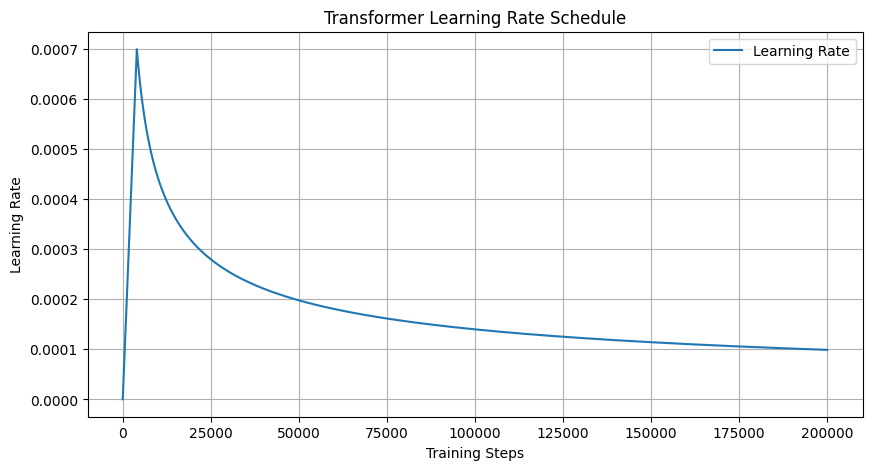

In [21]:
# 논문에 나온 공식을 참고하여 커스텀 learning_rate 스케쥴러를 통한 adam optimizer사용
def get_lr_lambda(d_model, warmup_steps=4000):
    d_model = float(d_model)
    def lr_lambda(step):
        # step은 0부터 시작하므로 +1로 보정
        step = step + 1
        return (d_model ** -0.5) * min(step ** -0.5, step * (warmup_steps ** -1.5))
    return lr_lambda

# 하이퍼파라미터 설정
d_model = 512
warmup_steps = 4000
total_steps = 200000  # 총 학습 스텝

# 학습률 스케줄 시각화
steps = np.arange(1, total_steps + 1)
learning_rates = [get_lr_lambda(d_model, warmup_steps)(step) for step in steps]

# 그래프 출력
plt.figure(figsize=(10, 5))
plt.plot(steps, learning_rates, label="Learning Rate")
plt.xlabel("Training Steps")
plt.ylabel("Learning Rate")
plt.title("Transformer Learning Rate Schedule")
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# Optimizer 정의
optimizer = optim.Adam(model.parameters(), betas=(0.9, 0.98), eps=1e-9)

# Scheduler 정의
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=get_lr_lambda(D_MODEL, warmup_steps=4000))

# loss function 정의
loss_function = nn.CrossEntropyLoss(ignore_index=sp.pad_id())

def accuracy_function(y_pred, y_true, pad_id=0):
    """
    y_pred: (batch_size, seq_len, vocab_size)
    y_true: (batch_size, seq_len)
    """
    preds = y_pred.argmax(dim=-1)  # (batch_size, seq_len)
    mask = (y_true != pad_id)
    correct = (preds == y_true) & mask
    acc = correct.float().sum() / mask.float().sum()
    return acc

In [23]:
def train_step(model, batch, optimizer, loss_function, device):
    model.train()
    enc_input, dec_input, target = [x.to(device) for x in batch]

    optimizer.zero_grad()

    # 모델 포워드 패스
    logits = model(enc_input, dec_input)  # (batch_size, seq_len, vocab_size)

    # Loss 계산 (패딩 토큰 무시)
    loss = loss_function(logits.permute(0, 2, 1), target)  # (batch_size, vocab_size, seq_len) 필요

    # Backpropagation
    loss.backward()
    optimizer.step()

    return loss.item(), accuracy_function(logits, target, pad_id=sp.pad_id())

def train(model, dataloader, optimizer, loss_function, scheduler, num_epochs, device):
    model.to(device)

    for epoch in range(num_epochs):
        total_loss, total_acc = 0, 0
        for step, batch in enumerate(dataloader):
            loss, acc = train_step(model, batch, optimizer, loss_function, device)
            total_loss += loss
            total_acc += acc

            # 일정 스텝마다 로그 출력
            if step % 100 == 0:
                print(f"[Epoch {epoch+1}, Step {step}] Loss: {loss:.4f}, Acc: {acc:.4f}")

            # 학습률 스케줄러 업데이트
            scheduler.step()

        avg_loss = total_loss / len(dataloader)
        avg_acc = total_acc / len(dataloader)
        print(f"Epoch {epoch+1} Completed - Avg Loss: {avg_loss:.4f}, Avg Acc: {avg_acc:.4f}")

In [24]:
%%time

train(
    model=model,
    dataloader=dataloader,
    optimizer=optimizer,
    loss_function=loss_function,
    scheduler=scheduler,
    num_epochs=25,  # 원하는 에폭 수
    device=device
)

[Epoch 1, Step 0] Loss: 9.3943, Acc: 0.0000
[Epoch 1, Step 100] Loss: 9.4178, Acc: 0.0000
[Epoch 1, Step 200] Loss: 9.4591, Acc: 0.0000
[Epoch 1, Step 300] Loss: 9.3983, Acc: 0.0000
Epoch 1 Completed - Avg Loss: 9.3805, Avg Acc: 0.0001
[Epoch 2, Step 0] Loss: 9.3511, Acc: 0.0000
[Epoch 2, Step 100] Loss: 9.3459, Acc: 0.0000
[Epoch 2, Step 200] Loss: 9.3384, Acc: 0.0000
[Epoch 2, Step 300] Loss: 9.2511, Acc: 0.0000
Epoch 2 Completed - Avg Loss: 9.3262, Avg Acc: 0.0002
[Epoch 3, Step 0] Loss: 9.3363, Acc: 0.0000
[Epoch 3, Step 100] Loss: 9.2336, Acc: 0.0000
[Epoch 3, Step 200] Loss: 9.2090, Acc: 0.0000
[Epoch 3, Step 300] Loss: 9.2215, Acc: 0.0000
Epoch 3 Completed - Avg Loss: 9.2147, Avg Acc: 0.0009
[Epoch 4, Step 0] Loss: 9.1966, Acc: 0.0046
[Epoch 4, Step 100] Loss: 9.0736, Acc: 0.0096
[Epoch 4, Step 200] Loss: 9.1216, Acc: 0.0000
[Epoch 4, Step 300] Loss: 8.9349, Acc: 0.0051
Epoch 4 Completed - Avg Loss: 9.0429, Avg Acc: 0.0039
[Epoch 5, Step 0] Loss: 9.0163, Acc: 0.0093
[Epoch 5, St

# 테스트하기

In [25]:
def decoder_inference(model, sentence, tokenizer, device='cpu'):
    START_TOKEN = tokenizer.bos_id()
    END_TOKEN = tokenizer.eos_id()
    MAX_LENGTH = 30


    # 전처리
    sentence = preprocess_sentence(sentence)

    # 인코더 입력: [START] + 인코딩 + [END]
    enc_input_ids = [START_TOKEN] + tokenizer.encode(sentence) + [END_TOKEN]
    # 차원 확장: (batch_size=1, seq_len)
    enc_input = torch.tensor([enc_input_ids], dtype=torch.long, device=device)

    # 디코더 입력(dec_input)을 START_TOKEN만 포함한 상태로 시작
    dec_input = torch.tensor([[START_TOKEN]], dtype=torch.long, device=device)

    model.eval()  # 모델 평가 모드
    with torch.no_grad():
        for i in range(MAX_LENGTH):
            # 모델 forward: (enc_input, dec_input) -> (batch_size=1, seq_len, vocab_size)
            logits = model(enc_input, dec_input)

            # 마지막 타임스텝의 예측만 추출: shape (1, 1, vocab_size)
            # logits[:, -1, :] -> (1, vocab_size)
            last_step_logits = logits[:, -1, :]

            # argmax로 가장 높은 확률의 토큰 선택
            predicted_id = torch.argmax(last_step_logits, dim=-1)  # shape: (1,)

            # 종료 토큰이면 중단
            if predicted_id.item() == END_TOKEN:
                break

            # 디코더 입력(dec_input)에 예측 토큰을 이어붙임
            predicted_id = predicted_id.unsqueeze(0)  # shape (1,1)
            dec_input = torch.cat([dec_input, predicted_id], dim=1)

    # 최종 시퀀스: dec_input: (1, seq_len)에서 (seq_len,)로
    output_sequence = dec_input.squeeze(0).tolist()  # e.g. [START_TOKEN, ..., 토큰들...]

    return output_sequence

In [26]:
def sentence_generation(model, sentence, tokenizer, device='cpu'):
    # 디코더 인퍼런스 -> 예측된 토큰 시퀀스
    output_seq = decoder_inference(model, sentence, tokenizer, device=device)

    # 토크나이저로 디코딩 (패딩, START/END 토큰 등은 제외하거나 처리)
    # 여기서는 단순히 tokenizer.decode() 직접 호출
    predicted_sentence = tokenizer.decode(
        [token for token in output_seq if token < tokenizer.GetPieceSize()]
    )

    print("입력 :", sentence)
    print("출력 :", predicted_sentence)
    return predicted_sentence

In [32]:
sentence = '나 연기 너무 못해 거짓말 못하겠어'
sentence_generation(model, sentence, sp, device)

입력 : 나 연기 너무 못해 거짓말 못하겠어
출력 : .


'.'